In [1]:
#importing libraries 
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...


In [51]:
# reading the datasets into pandas

stock_price = pd.read_csv('TSLAAA (1).csv')
stock_headlines = pd.read_csv('india-news-headlines.csv')
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-03,44.912666,52.409332,44.901333,52.000000,52.000000,705975000
1,2020-02-04,58.863998,64.599335,55.591999,59.137333,59.137333,914082000
2,2020-02-05,54.883999,56.398666,46.940666,48.980000,48.980000,726357000
3,2020-02-06,46.661331,53.055332,45.799999,49.930668,49.930668,598212000
4,2020-02-07,48.703335,51.316666,48.666668,49.871334,49.871334,255952500


In [52]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [53]:
#Feature Engineering
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price),len(stock_headlines)

(766, 3650970)

In [54]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [55]:
#Stock Price Data
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-02-03,52.000000,44.912666,52.409332,44.901333,705975000
2020-02-04,59.137333,58.863998,64.599335,55.591999,914082000
2020-02-05,48.980000,54.883999,56.398666,46.940666,726357000
2020-02-06,49.930668,46.661331,53.055332,45.799999,598212000
2020-02-07,49.871334,48.703335,51.316666,48.666668,255952500
...,...,...,...,...,...
2023-02-09,207.320007,207.779999,214.000000,204.770004,215431400
2023-02-10,196.889999,202.229996,206.199997,192.889999,204193800
2023-02-13,194.639999,194.419998,196.300003,187.610001,172475500


In [56]:
#Stock News Headlines Data
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


In [57]:
#Combining Stock Data and stock headlines and storing them into dataframe called stock_data

# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-02-03,52.000000,44.912666,52.409332,44.901333,705975000.0,Fan holds up banner asking if season 13 of the...
2020-02-04,59.137333,58.863998,64.599335,55.591999,914082000.0,Students explored their fashion fundas at this...
2020-02-05,48.980000,54.883999,56.398666,46.940666,726357000.0,Heritage preservation club at Tennur school fo...
2020-02-06,49.930668,46.661331,53.055332,45.799999,598212000.0,Nashik traders seek rollback of onion export b...
2020-02-07,49.871334,48.703335,51.316666,48.666668,255952500.0,T minority commission to hold nat'l-level conf...
...,...,...,...,...,...,...
2022-03-25,336.880005,336.000000,340.600006,332.440002,62031600.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,363.946655,355.033325,365.959991,351.200012,102506100.0,As fashion becomes democratic; demand for styl...
2022-03-29,366.523346,369.329987,371.589996,357.703339,73614900.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,364.663330,363.723328,371.316681,361.333344,59865000.0,"I will not give in to trends: Dossmode,The tim..."


In [58]:
#Calculating Sentiment Scores
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-02-03,52.000000,44.912666,52.409332,44.901333,705975000.0,Fan holds up banner asking if season 13 of the...,,,,
2020-02-04,59.137333,58.863998,64.599335,55.591999,914082000.0,Students explored their fashion fundas at this...,,,,
2020-02-05,48.980000,54.883999,56.398666,46.940666,726357000.0,Heritage preservation club at Tennur school fo...,,,,
2020-02-06,49.930668,46.661331,53.055332,45.799999,598212000.0,Nashik traders seek rollback of onion export b...,,,,
2020-02-07,49.871334,48.703335,51.316666,48.666668,255952500.0,T minority commission to hold nat'l-level conf...,,,,


In [59]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [60]:
# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-02-03,52.000000,44.912666,52.409332,44.901333,705975000.0,Fan holds up banner asking if season 13 of the...,-0.9980,0.119,0.773,0.108
2020-02-04,59.137333,58.863998,64.599335,55.591999,914082000.0,Students explored their fashion fundas at this...,-0.9999,0.171,0.745,0.084
2020-02-05,48.980000,54.883999,56.398666,46.940666,726357000.0,Heritage preservation club at Tennur school fo...,-0.9999,0.150,0.773,0.076
2020-02-06,49.930668,46.661331,53.055332,45.799999,598212000.0,Nashik traders seek rollback of onion export b...,-0.9999,0.156,0.762,0.082
2020-02-07,49.871334,48.703335,51.316666,48.666668,255952500.0,T minority commission to hold nat'l-level conf...,-0.9999,0.140,0.788,0.072


In [61]:
#Finalising Stock Data
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()
     

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-02-03,52.000000,-0.9980,0.119,0.773,0.108,44.912666,52.409332,44.901333,705975000.0
2020-02-04,59.137333,-0.9999,0.171,0.745,0.084,58.863998,64.599335,55.591999,914082000.0
2020-02-05,48.980000,-0.9999,0.150,0.773,0.076,54.883999,56.398666,46.940666,726357000.0
2020-02-06,49.930668,-0.9999,0.156,0.762,0.082,46.661331,53.055332,45.799999,598212000.0
2020-02-07,49.871334,-0.9999,0.140,0.788,0.072,48.703335,51.316666,48.666668,255952500.0


In [62]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_datafinal.csv')

In [63]:
stock_data=pd.read_csv('stock_datafinal.csv')
stock_data.head()

,Unnamed: 0,Close,compound,negative,neutral,positive,Open,High,Low,Volume
0,2020-02-03,52.000000,-0.9980,0.119,0.773,0.108,44.912666,52.409332,44.901333,705975000.0
1,2020-02-04,59.137333,-0.9999,0.171,0.745,0.084,58.863998,64.599335,55.591999,914082000.0
2,2020-02-05,48.980000,-0.9999,0.150,0.773,0.076,54.883999,56.398666,46.940666,726357000.0
3,2020-02-06,49.930668,-0.9999,0.156,0.762,0.082,46.661331,53.055332,45.799999,598212000.0
4,2020-02-07,49.871334,-0.9999,0.140,0.788,0.072,48.703335,51.316666,48.666668,255952500.0


In [64]:
# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-02-03,52.000000,-0.9980,0.119,0.773,0.108,44.912666,52.409332,44.901333,705975000.0
2020-02-04,59.137333,-0.9999,0.171,0.745,0.084,58.863998,64.599335,55.591999,914082000.0
2020-02-05,48.980000,-0.9999,0.150,0.773,0.076,54.883999,56.398666,46.940666,726357000.0
2020-02-06,49.930668,-0.9999,0.156,0.762,0.082,46.661331,53.055332,45.799999,598212000.0
2020-02-07,49.871334,-0.9999,0.140,0.788,0.072,48.703335,51.316666,48.666668,255952500.0


In [65]:
#lets do again Feature Engineering of Stock Data
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(546, 9)

In [66]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [67]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,5.460000e+02
mean,198.803669,-0.981168,0.127780,0.795495,0.076720,198.697694,203.346415,193.744304,1.406501e+08
std,99.588863,0.190229,0.018412,0.023262,0.011671,99.616641,101.730281,97.278896,1.069800e+08
min,24.081333,-1.000000,0.076000,0.728000,0.044000,24.980000,26.990667,23.367332,2.940180e+07
25%,113.075832,-0.999900,0.115250,0.780000,0.069000,113.614166,122.934998,110.350500,6.876368e+07
50%,217.661667,-0.999800,0.129000,0.793000,0.077000,217.811668,221.791664,212.529999,1.003756e+08
75%,268.498337,-0.999600,0.140000,0.810000,0.084000,270.053344,273.604156,263.460831,1.837555e+08
max,409.970001,0.999800,0.199000,0.877000,0.127000,411.470001,414.496674,405.666656,9.140820e+08


In [68]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 2020-02-03 to 2022-03-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     546 non-null    float64
 1   compound  546 non-null    float64
 2   negative  546 non-null    float64
 3   neutral   546 non-null    float64
 4   positive  546 non-null    float64
 5   Open      546 non-null    float64
 6   High      546 non-null    float64
 7   Low       546 non-null    float64
 8   Volume    546 non-null    float64
dtypes: float64(9)
memory usage: 42.7+ KB


Text(0, 0.5, 'Close Price in $')

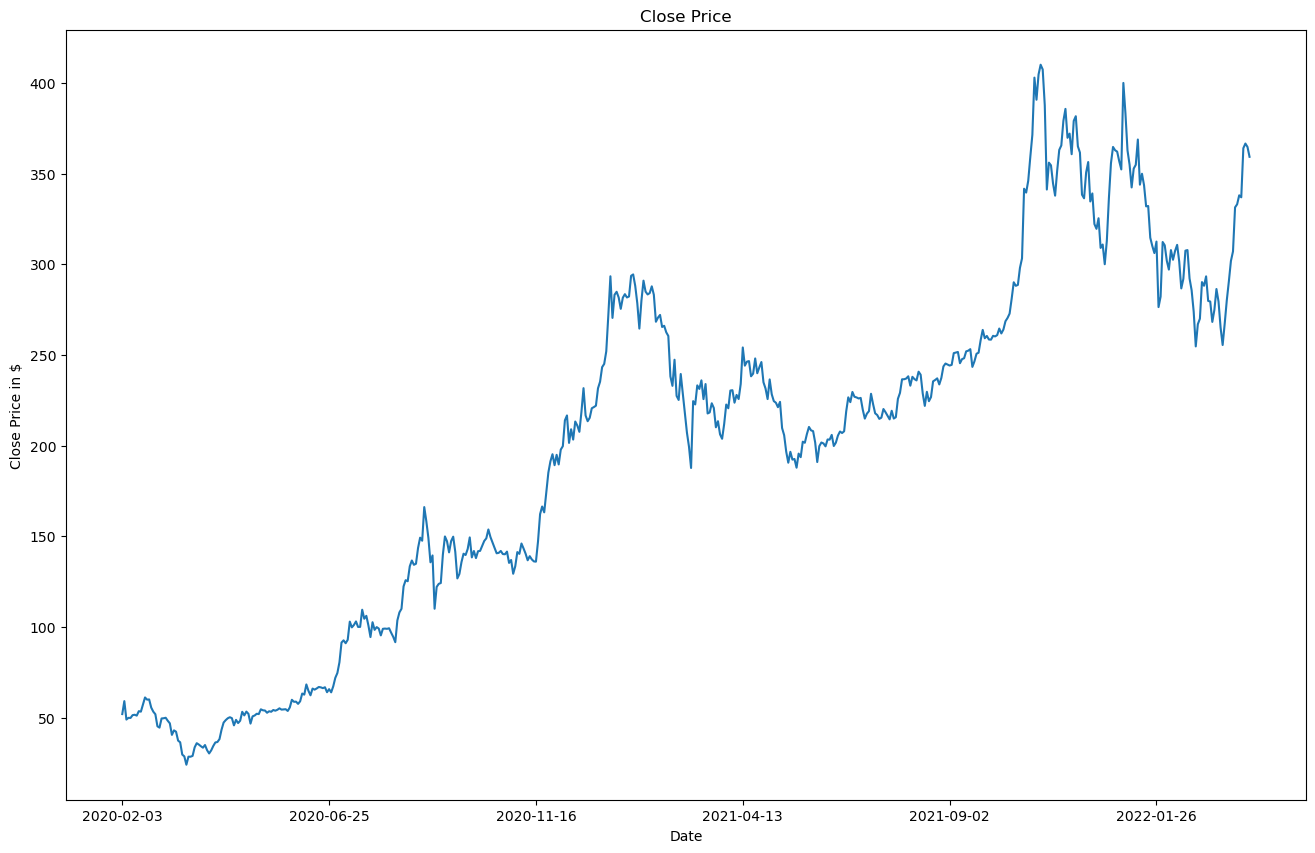

In [69]:
#Exploratory Data Analysis of Stock Data
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price in $')

In [70]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-11,51.851905,-0.999629,0.150000,0.766143,0.083571,51.230190,54.954190,48.942000,5.351970e+08
2020-02-12,51.730857,-0.999714,0.147571,0.773571,0.078571,52.222380,54.988572,49.797714,4.601059e+08
2020-02-13,50.939810,-0.999714,0.147143,0.773286,0.079286,50.878381,53.550571,48.856000,3.858570e+08


<AxesSubplot:xlabel='Date'>

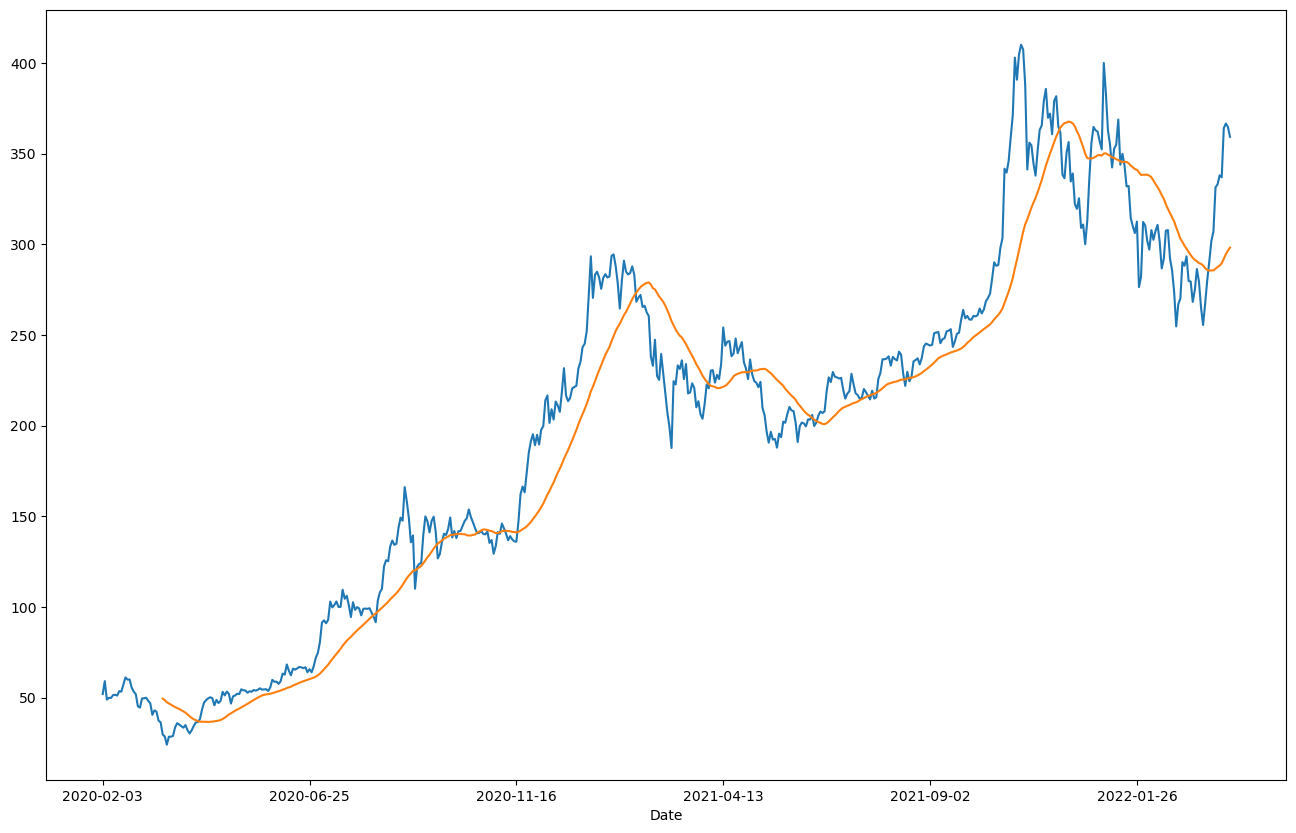

In [71]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [72]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-02-03,52.000000,-0.9980,0.119,0.773,0.108,44.912666,52.409332,44.901333,705975000.0
2020-02-04,59.137333,-0.9999,0.171,0.745,0.084,58.863998,64.599335,55.591999,914082000.0
2020-02-05,48.980000,-0.9999,0.150,0.773,0.076,54.883999,56.398666,46.940666,726357000.0
2020-02-06,49.930668,-0.9999,0.156,0.762,0.082,46.661331,53.055332,45.799999,598212000.0
2020-02-07,49.871334,-0.9999,0.140,0.788,0.072,48.703335,51.316666,48.666668,255952500.0
...,...,...,...,...,...,...,...,...,...
2022-03-25,336.880005,-0.9999,0.160,0.774,0.066,336.000000,340.600006,332.440002,62031600.0
2022-03-28,363.946655,-0.9999,0.151,0.763,0.086,355.033325,365.959991,351.200012,102506100.0
2022-03-29,366.523346,-0.9998,0.131,0.789,0.080,369.329987,371.589996,357.703339,73614900.0


In [73]:
#Data Preparation for Modelling
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 436
Number of records in Test Data: 110


In [74]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2020-02-04     59.137333
2020-02-05     48.980000
2020-02-06     49.930668
2020-02-07     49.871334
2020-02-10     51.418667
                 ...    
2022-03-25    336.880005
2022-03-28    363.946655
2022-03-29    366.523346
2022-03-30    364.663330
2022-03-31    359.200012
Name: Close, Length: 545, dtype: float64

In [75]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)
     

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2020-02-04,59.137333,48.980000,-0.9999,-0.9999,914082000.0,58.863998,64.599335,55.591999
2020-02-05,48.980000,49.930668,-0.9999,-0.9999,726357000.0,54.883999,56.398666,46.940666
2020-02-06,49.930668,49.871334,-0.9999,-0.9999,598212000.0,46.661331,53.055332,45.799999
2020-02-07,49.871334,51.418667,-0.9999,-0.9999,255952500.0,48.703335,51.316666,48.666668
2020-02-10,51.418667,51.625332,-0.9999,-0.9999,370338000.0,53.333332,54.666000,50.160000
2020-02-11,51.625332,51.152668,-0.9999,-0.9986,175462500.0,51.252666,52.234001,50.533333
2020-02-12,51.152668,53.599998,-0.9986,-0.9999,180337500.0,51.858002,52.650002,50.891335
2020-02-13,53.599998,53.335335,-0.9999,-0.9999,394339500.0,49.456001,54.533333,49.000000
2020-02-14,53.335335,57.226665,-0.9999,-0.9998,235405500.0,52.481335,54.198002,52.366669


In [76]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2020-02-04     48.980000
2020-02-05     49.930668
2020-02-06     49.871334
2020-02-07     51.418667
2020-02-10     51.625332
                 ...    
2022-03-24    336.880005
2022-03-25    363.946655
2022-03-28    366.523346
2022-03-29    364.663330
2022-03-30    359.200012
Name: close_price_shifted, Length: 544, dtype: float64

In [77]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2020-02-04,59.137333,-0.9999,-0.9999,914082000.0,58.863998,64.599335,55.591999
2020-02-05,48.980000,-0.9999,-0.9999,726357000.0,54.883999,56.398666,46.940666
2020-02-06,49.930668,-0.9999,-0.9999,598212000.0,46.661331,53.055332,45.799999
2020-02-07,49.871334,-0.9999,-0.9999,255952500.0,48.703335,51.316666,48.666668
2020-02-10,51.418667,-0.9999,-0.9999,370338000.0,53.333332,54.666000,50.160000
...,...,...,...,...,...,...,...
2022-03-24,337.973328,-0.9999,-0.9999,68920800.0,336.576660,341.496674,329.600006
2022-03-25,336.880005,-0.9999,-0.9999,62031600.0,336.000000,340.600006,332.440002
2022-03-28,363.946655,-0.9999,-0.9998,102506100.0,355.033325,365.959991,351.200012


In [78]:
#Scaling the Target Variable and the Feature Dataset
#Since we are using LSTM to predict stock prices, 
#which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data.
#Right now, if the data is observed, it is present in different scales. 
#Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records.
#Here a feature range of (-1,1) is used.

# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y
     

(array([[-0.81831029, -0.99989999, -0.99989999, ..., -0.82465783,
         -0.80589375, -0.83141656],
        [-0.87095414, -0.99989999, -0.99989999, ..., -0.84525344,
         -0.84821913, -0.87667604],
        [-0.86602698, -0.99989999, -0.99989999, ..., -0.88780392,
         -0.86547478, -0.88264344],
        ...,
        [ 0.76146827, -0.99989999, -0.99979998, ...,  0.70795272,
          0.74949197,  0.7150576 ],
        [ 0.77482285, -0.99979998, -0.99989999, ...,  0.78193478,
          0.77854961,  0.74907977],
        [ 0.76518268, -0.99989999, -0.99989999, ...,  0.75292156,
          0.77713897,  0.76807015]]),
 array([[-8.70954143e-01],
        [-8.66026981e-01],
        [-8.66334499e-01],
        [-8.58314917e-01],
        [-8.57243805e-01],
        [-8.59693548e-01],
        [-8.47009423e-01],
        [-8.48381129e-01],
        [-8.28212981e-01],
        [-8.07820229e-01],
        [-8.14043080e-01],
        [-8.13493704e-01],
        [-8.36716294e-01],
        [-8.48422608e-

In [79]:
#Dividing the dataset into Training and Test
#Normally for any other dataset train_test_split from sklearn package is used, 
#but for time series data like stock prices which is dependent on date, 
#the dataset is divided into train and test dataset in a different way as shown below.
#In timeseries data, an observation for a particular date is always dependent on the previous date records.


# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)
     

Number of rows and columns in the Training set X: (436, 7) and y: (436, 1)
Number of rows and columns in the Test set X: (107, 7) and y: (107, 1)


In [80]:
#Reshaping the Feature Dataset

# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)


Shape of Training set X: (436, 7, 1)
Shape of Test set X: (107, 7, 1)


In [81]:
#Stock Data Modelling

# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 100)            40800     
                                                                 
 dropout_3 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_4 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [82]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
36/36 [==============================] - 14s 92ms/step - loss: 0.1541 - val_loss: 0.2142
Epoch 2/50
36/36 [==============================] - 1s 23ms/step - loss: 0.0726 - val_loss: 0.0613
Epoch 3/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0287 - val_loss: 0.0266
Epoch 4/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0252 - val_loss: 0.0306
Epoch 5/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0173 - val_loss: 0.0449
Epoch 6/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0142 - val_loss: 0.0278
Epoch 7/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0153 - val_loss: 0.0268
Epoch 8/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0144 - val_loss: 0.0291
Epoch 9/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0165 - val_loss: 0.0307
Epoch 10/50
36/36 [==============================] - 1s 26ms/step - loss: 0.0152 - val_loss: 0.0243
Epoch 11

In [83]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved')

Model is saved


In [84]:
#Predictions

# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

4/4 [==============================] - 2s 9ms/step
Predictions:


array([[308.75095],
       [311.97345],
       [311.01987],
       [288.62186],
       [305.9556 ]], dtype=float32)

In [85]:
#Model Evaluation

# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

107/107 [==============================] - 1s 6ms/step - loss: 0.0859
Train Loss = 0.0163
Test Loss = 0.0859


In [89]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 56.5376


In [86]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

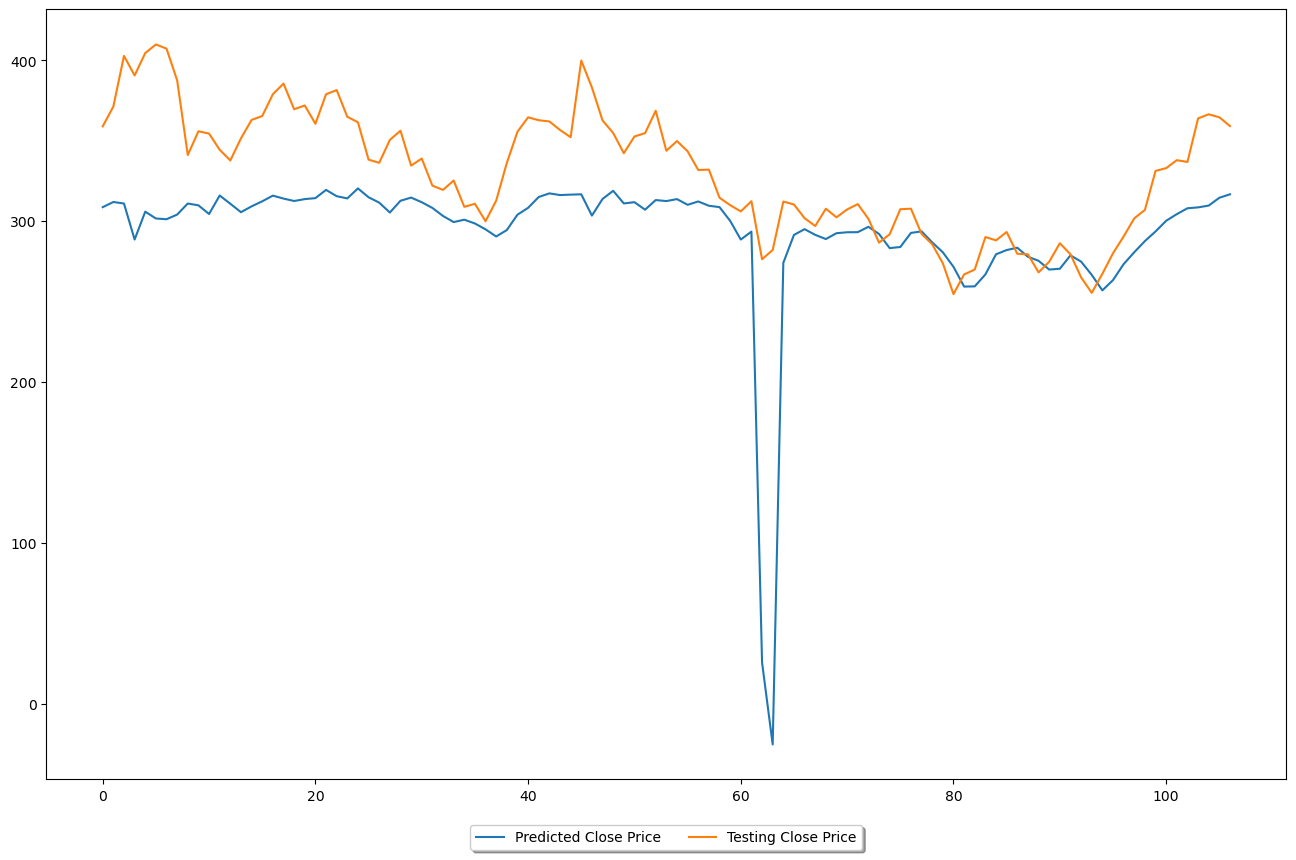

In [87]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()